In [ ]:
!pip install -q torch-snippets

from torch_snippets import *
from torch_snippets.torch_loader import Report
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
from torch import nn
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [ ]:
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.33MB/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [ ]:
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            #nn.Linear(64, 12),  nn.ReLU(True),
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            #nn.Linear(latent_dim, 12), nn.ReLU(True),
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [ ]:
# from torchsummary import summary
# model = AutoEncoder(3).to(device)
# summary(model, torch.zeros(2,1,28,28));

##########################
from torchsummary import summary
model = AutoEncoder(3).to(device)

# Provide input shape as a tuple instead of a tensor
summary(model, (1, 28, 28))  # (channels, height, width) for single image

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                    [-1, 3]             195
            Linear-6                   [-1, 64]             256
              ReLU-7                   [-1, 64]               0
            Linear-8                  [-1, 128]           8,320
              ReLU-9                  [-1, 128]               0
           Linear-10                  [-1, 784]         101,136
             Tanh-11                  [-1, 784]               0
Total params: 218,643
Trainable params: 218,643
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000  trn_loss: 0.255  val_loss: 0.187  (39.12s - 156.48s remaining)
EPOCH: 2.000  trn_loss: 0.173  val_loss: 0.163  (61.25s - 91.87s remaining)
EPOCH: 3.000  trn_loss: 0.159  val_loss: 0.155  (83.38s - 55.58s remaining)
EPOCH: 4.000  trn_loss: 0.153  val_loss: 0.150  (105.63s - 26.41s remaining)
EPOCH: 5.000  trn_loss: 0.149  val_loss: 0.147  (129.38s - 0.00s remaining)


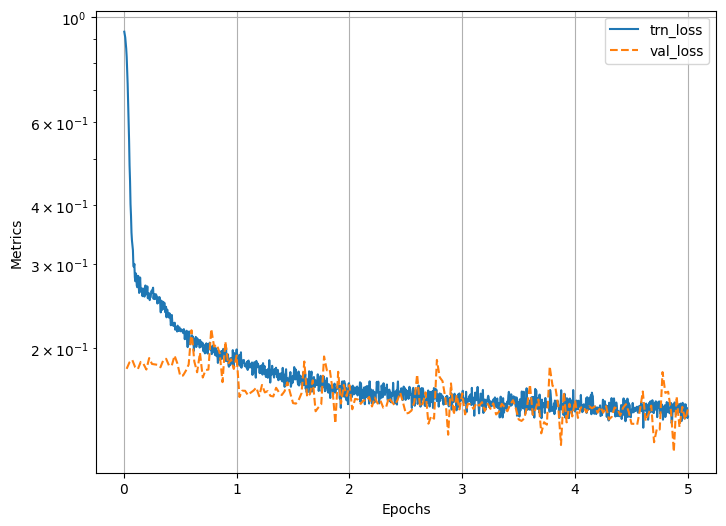

In [ ]:
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)
log.plot(log=True)

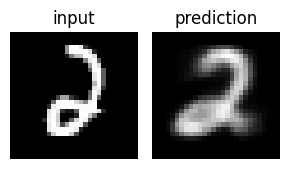

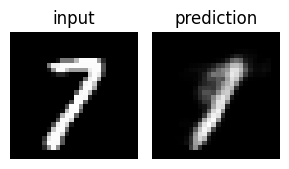

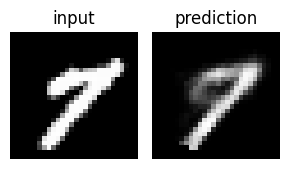

In [ ]:
import matplotlib.pyplot as plt
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

EPOCH: 1.000  trn_loss: 0.234  val_loss: 0.134  (21.48s - 85.90s remaining)
EPOCH: 2.000  trn_loss: 0.114  val_loss: 0.100  (43.38s - 65.07s remaining)
EPOCH: 3.000  trn_loss: 0.091  val_loss: 0.082  (65.44s - 43.63s remaining)
EPOCH: 4.000  trn_loss: 0.078  val_loss: 0.072  (87.37s - 21.84s remaining)
EPOCH: 5.000  trn_loss: 0.071  val_loss: 0.065  (108.60s - 0.00s remaining)


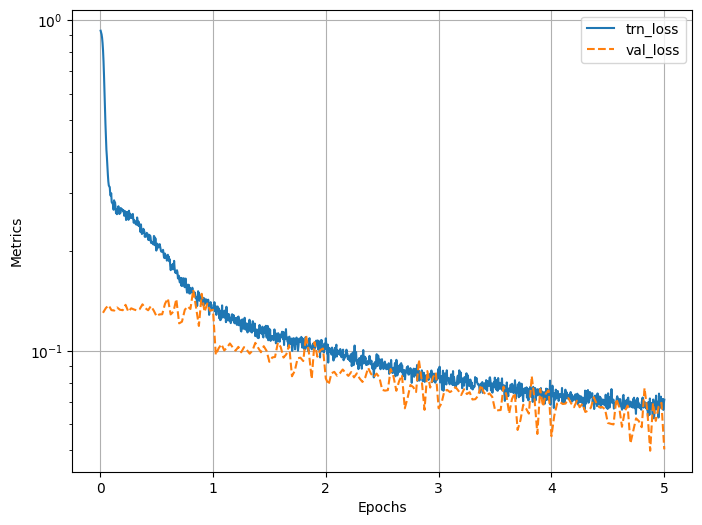

EPOCH: 1.000  trn_loss: 0.267  val_loss: 0.211  (22.06s - 88.23s remaining)
EPOCH: 2.000  trn_loss: 0.201  val_loss: 0.190  (43.96s - 65.95s remaining)
EPOCH: 3.000  trn_loss: 0.185  val_loss: 0.179  (65.63s - 43.75s remaining)
EPOCH: 4.000  trn_loss: 0.177  val_loss: 0.173  (87.20s - 21.80s remaining)
EPOCH: 5.000  trn_loss: 0.172  val_loss: 0.170  (109.28s - 0.00s remaining)


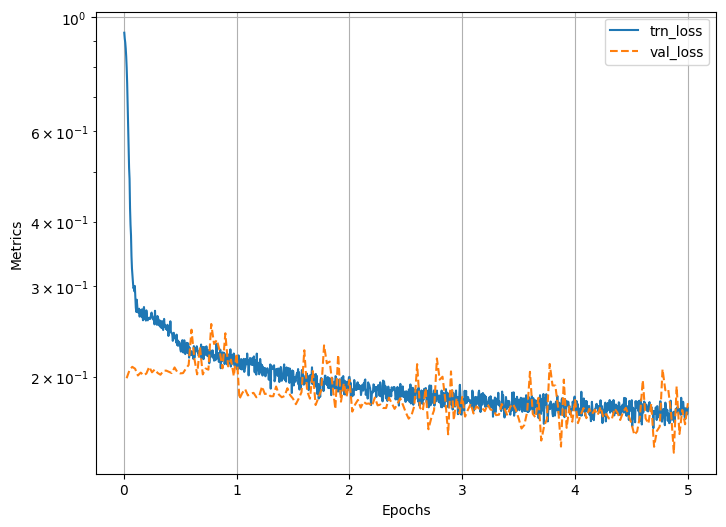

EPOCH: 1.000  trn_loss: 0.264  val_loss: 0.198  (22.06s - 88.25s remaining)
EPOCH: 2.000  trn_loss: 0.183  val_loss: 0.171  (43.83s - 65.74s remaining)
EPOCH: 3.000  trn_loss: 0.166  val_loss: 0.161  (65.58s - 43.72s remaining)
EPOCH: 4.000  trn_loss: 0.158  val_loss: 0.154  (87.68s - 21.92s remaining)
EPOCH: 5.000  trn_loss: 0.153  val_loss: 0.150  (109.86s - 0.00s remaining)


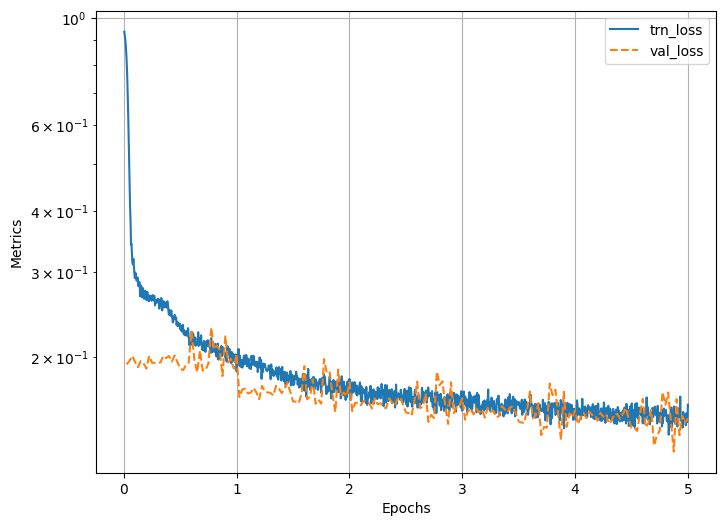

EPOCH: 1.000  trn_loss: 0.248  val_loss: 0.166  (21.78s - 87.12s remaining)
EPOCH: 2.000  trn_loss: 0.150  val_loss: 0.139  (43.57s - 65.36s remaining)
EPOCH: 3.000  trn_loss: 0.132  val_loss: 0.128  (65.65s - 43.77s remaining)
EPOCH: 4.000  trn_loss: 0.125  val_loss: 0.122  (87.87s - 21.97s remaining)
EPOCH: 5.000  trn_loss: 0.121  val_loss: 0.119  (109.69s - 0.00s remaining)


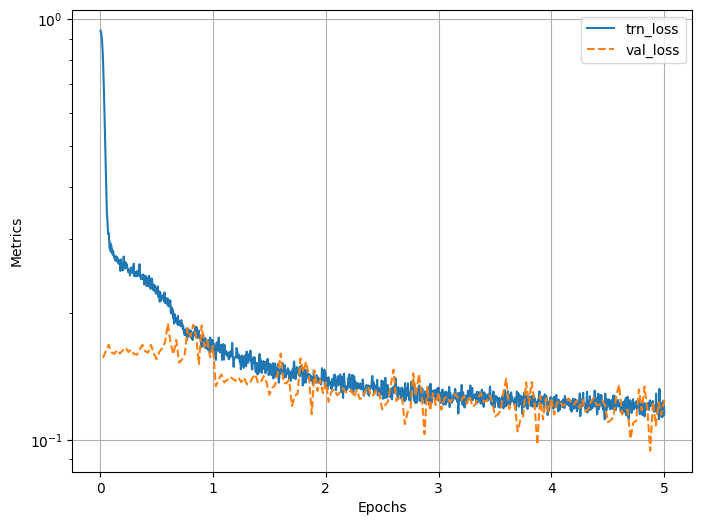

EPOCH: 1.000  trn_loss: 0.245  val_loss: 0.147  (21.73s - 86.92s remaining)
EPOCH: 2.000  trn_loss: 0.126  val_loss: 0.109  (44.12s - 66.18s remaining)
EPOCH: 3.000  trn_loss: 0.104  val_loss: 0.098  (66.36s - 44.24s remaining)
EPOCH: 4.000  trn_loss: 0.098  val_loss: 0.094  (88.36s - 22.09s remaining)
EPOCH: 5.000  trn_loss: 0.094  val_loss: 0.090  (110.19s - 0.00s remaining)


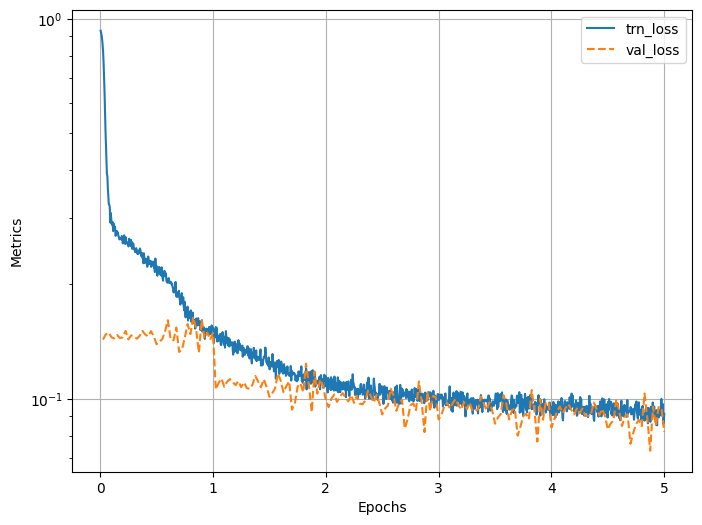

In [ ]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

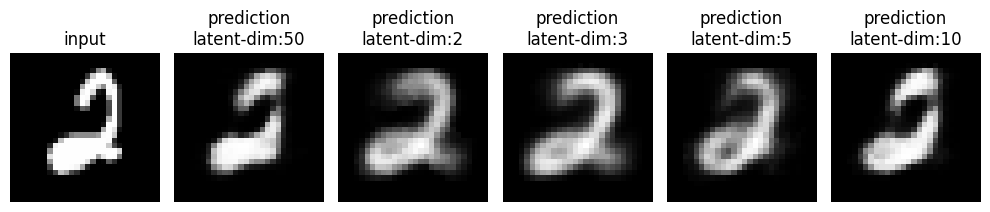

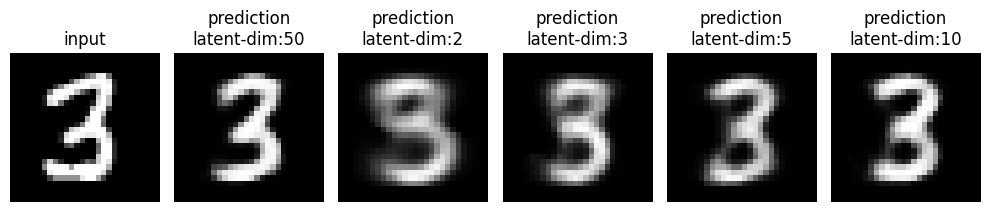

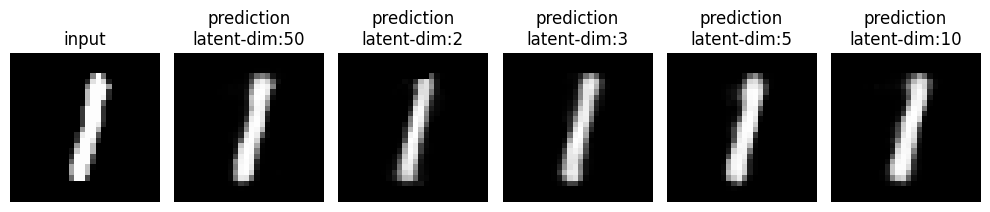

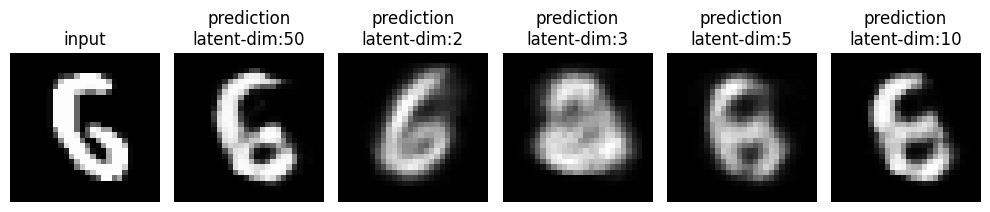

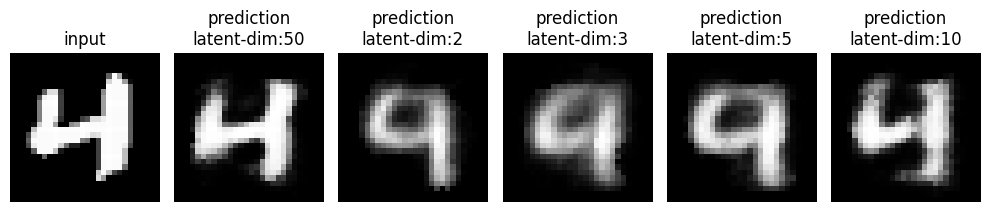

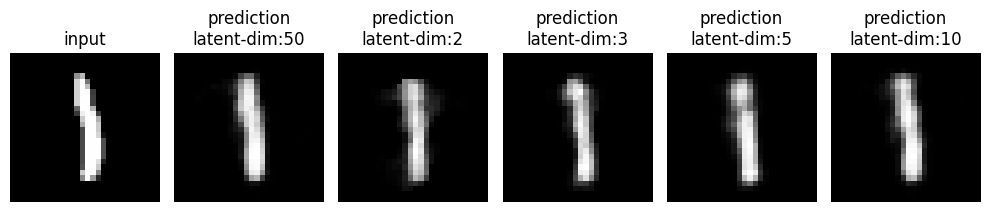

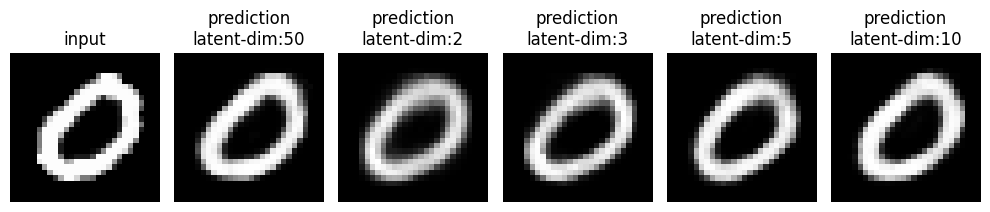

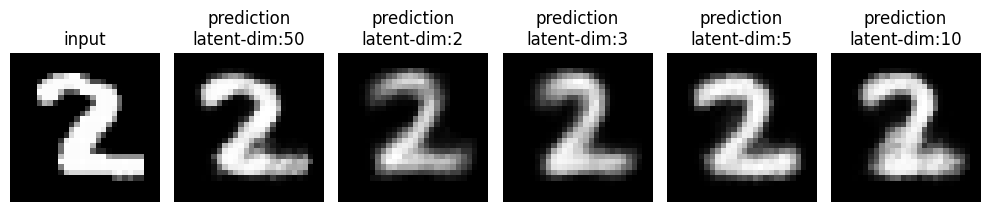

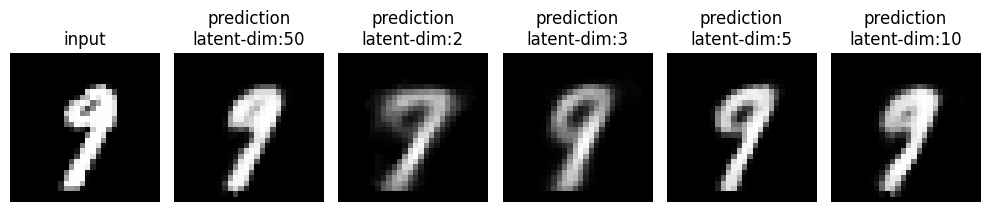

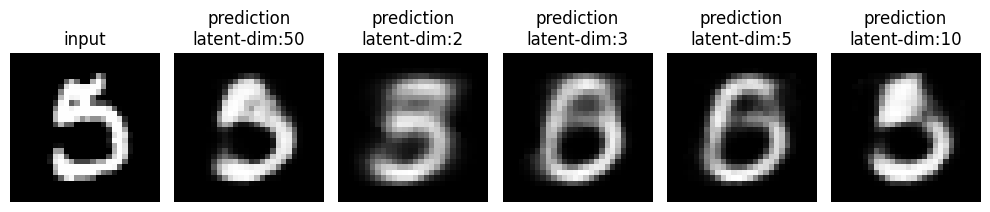

In [ ]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()